In [1]:
import nltk
import spacy
import tensorflow
import numpy as np
from datetime import datetime
from nltk.stem import PorterStemmer

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# !python -m spacy download en_core_web_lg

In [4]:
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

---
### NLP pre-processing...
----

In [5]:
def tokenize_n_filter(word_lst):
  punc = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

  word_lst = nltk.word_tokenize(" ".join(word_lst).lower())
  word_lst = [word for word in word_lst if word not in punc]
  
  return word_lst

In [6]:

def lemmatize(text):
  doc = nlp(text)
  lemma_lst = [token.lemma_ for token in doc]

  return lemma_lst
  

In [7]:

def bag_of_words(tokenized_sentence, all_words):
  vector = np.zeros(len(all_words))

  for idx, elem in enumerate(all_words):
    if elem in tokenized_sentence:
      vector[idx] = 1

  return vector
  

In [8]:
print(tokenize_n_filter(lemmatize("i I'm i am$%^&^&#@@* the bowrey eating eat ate eaten wanted wanting want wants")))

['i', 'i', 'be', 'i', 'am', 'the', 'bowrey', 'eat', 'eat', 'eat', 'eat', 'want', 'want', 'want', 'want']


---
### intents.json file data loading as python dict
---

In [9]:
import json

In [10]:
intents = json.load(open('/content/drive/MyDrive/Colab Notebooks/NLP/NLP Projects/CYBRIX general Contextual Chatbot/data/intents.json', 'rb'))

type(intents)

dict

In [11]:
all_words = []
tag_classes = []          ## y_train
xy = []

In [12]:
for intent in intents['intents']:
  tag = intent['tag']
  tag_classes.append(tag)

  for pattern in intent['patterns']:
    words = tokenize_n_filter(lemmatize(pattern))
    all_words.extend(words)
    xy.append((words, tag))
    

In [13]:
len(all_words), len(tag_classes)

(431, 34)

In [14]:
all_words = sorted(list(set(all_words)))
len(all_words)

166

In [15]:
tag_classes = sorted(list(set(tag_classes)))
print(len(tag_classes), tag_classes)

34 ['Identity', 'activity', 'age', 'appreciate', 'contact', 'covid19', 'cricket', 'cybrix', 'datetime', 'exclaim', 'goodbye', 'google', 'greeting', 'greetreply', 'haha', 'hours', 'inspire', 'insult', 'ishtiuk', 'jokes', 'news', 'nicetty', 'no', 'options', 'payments', 'product_inquiry', 'programmer', 'riddle', 'song', 'suggest', 'thanks', 'timer', 'weather', 'whatsup']


---
### dataset creation for Feed Forward ANN
---

In [16]:
x_train = []
y_train = []


for (pattern, tag) in xy:
  bag = bag_of_words(pattern, all_words)
  
  x_train.append(bag)
  label = tag_classes.index(tag)                  ## LabelEncoding... ;)
  y_train.append(label)


x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train)

In [17]:
np.unique(y_train).shape, y_train.shape

((34,), (161,))

In [18]:
y_train

array([11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10,
       10, 10, 10, 10, 10, 10, 30, 30, 30, 30, 30, 30, 23, 23, 23, 23, 23,
       23, 23, 19, 19, 19, 19, 19,  0,  0,  0,  0,  0,  0,  7,  7,  7,  8,
        8,  8,  8,  8,  8,  8,  8, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       14, 14, 14, 14, 14, 14, 26, 26, 26, 26, 17, 17, 17, 17, 17,  1,  1,
        9,  9,  9,  9,  9,  9,  9, 32, 32, 32, 18, 18, 18, 18,  4,  4,  4,
        4,  3,  3,  3,  3, 21, 21, 21, 22, 22, 22, 20, 20, 20, 20, 16, 16,
       16, 16,  6,  6, 28, 28, 28, 28, 28, 13, 13, 13, 13, 13, 13, 13, 13,
       31,  5, 29, 29, 29, 29, 29, 27, 27, 27,  2,  2,  2, 15, 15, 15, 25,
       25, 25, 25, 25, 24, 24, 24, 24])

In [19]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [20]:
early_stop = EarlyStopping(
    monitor="accuracy",
    patience=15,
    mode="auto",
    restore_best_weights=True
)

---
### FeedForward ANN model: to predict the Class (Tag) of users input sms
---

In [21]:
model = Sequential()

model.add(Dense(128, activation="relu", input_dim=len(x_train[0])))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(34, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               21376     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 34)                4

In [22]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = model.fit(x_train, y_train, epochs=50, callbacks=early_stop)

Epoch 1/50
6/6 [==============================] - 7s 13ms/step - loss: 3.5299 - accuracy: 0.0248
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 3.5052 - accuracy: 0.0745
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 3.4872 - accuracy: 0.1056
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 3.4610 - accuracy: 0.1304
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 3.4178 - accuracy: 0.1615
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 3.3689 - accuracy: 0.1366
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 3.3080 - accuracy: 0.1366
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 3.2187 - accuracy: 0.1615
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 3.0753 - accuracy: 0.2547
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 2.9926 - accuracy: 0.2484
Epoch 11/50
6/6 [=====================

In [24]:
y_pred = model.predict(x_train)

y_pred = np.array(list(map(np.argmax, y_pred)))

6/6 [==============================] - 0s 3ms/step


In [25]:
sum(y_train == y_pred) / len(y_train)

1.0

---
### saving the train Feed Forward ANN model
---

In [41]:
model.save("ANN_engine.h5")

In [42]:
np.array([x_train[0]]).shape

(1, 166)

In [27]:
list(map(np.argmax, model.predict(x_train[-1].reshape((1, len(x_train[0]))))))

1/1 [==============================] - 0s 19ms/step


[24]

In [28]:
y_train[-1]

24

In [29]:
import matplotlib.pyplot as plt

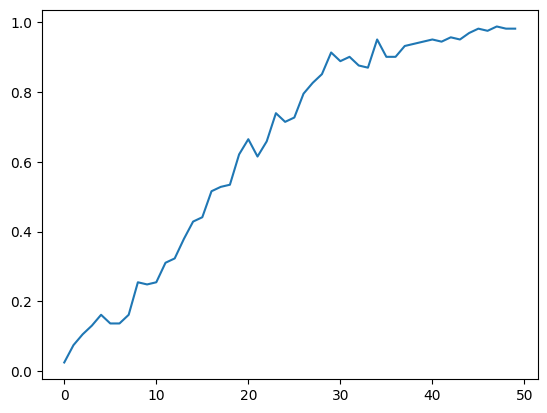

In [30]:
plt.plot(history.history["accuracy"])

---
### extra facility functions:
---

In [31]:
def datetime_process():
  return datetime.strftime(datetime.now(), "%Y-%m-%d %a || %I:%M %p")

In [32]:
def news_process():
  return "Current News: "

In [33]:
custom_actions = {'datetime': datetime_process, "news": news_process}

---
### Testing...
----

In [34]:
import random

In [37]:
run = True

while run:
  usr_inp = tokenize_n_filter(lemmatize(input("\nYou    : ")))

  bag = bag_of_words(usr_inp, all_words).reshape((1, len(x_train[0])))
  probs = model.predict(bag, verbose=0)

  if np.any(probs >= 0.70):
    tag_idx = list(map(np.argmax, probs))[0]
    tag = tag_classes[tag_idx]

    for intent in intents["intents"]:
      if tag in custom_actions.keys():
        print("Cybrix: ", custom_actions[tag](), end="\n")
        break
      elif intent["tag"] == tag:
        print("Cybrix :", random.choice(intent["responses"]), end="\n")

      if tag == "goodbye":
        run = False

  else:
    print("Cybrix :", random.choice(intents["noanswer"]), end="\n")


You    : who's going
Cybrix : Head over to his any of his social profiles to find out! | Linkedin: www.linkedin.com/in/ishtiuk-ahammed | Github: www.github.com/ishtiuk |

You    : what's going
Cybrix : All good..What about you?

You    : how's going
Cybrix : Everthing's fine. And you?

You    : yeah
Cybrix : Yup

You    : how are you
Cybrix : Everthing's fine. And you?

You    : what is the date now
Cybrix:  2023-05-02 Tue || 05:09 PM

You    : now time please
Cybrix:  2023-05-02 Tue || 05:09 PM

You    : datetime
Cybrix:  2023-05-02 Tue || 05:09 PM

You    : what products you have?
Cybrix : Our product range is extensive. Here's a short list: 
	* Keyboards
	* Mouses
	* GPUs
	* CPUs
	* Cooler Fan

You    : selling products list
Cybrix : We sell a variety of products. here's the list: 
	* Keyboards
	* Mouses
	* GPUs
	* CPUs
	* Cooler Fan

You    : thanks
Cybrix : Happy to help!

You    : apprecite
Cybrix : Sorry, can't understand you

You    : okey next time
Cybrix : Sorry, I didn't go

In [36]:
tag

'goodbye'

In [38]:
import pickle

In [40]:
pickle.dump(tag_classes, open('tag_classes.pkl', 'wb'))
pickle.dump(bag_of_words, open('bag_of_words.pkl', 'wb'))

In [43]:
from keras.models import load_model

In [46]:
load_model('ANN_engine.h5').summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               21376     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 34)                4